# **Individual Cases**

## **1. Import Libraries**

In [1]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

## **2. Import the Data**

##### 2.1 Load the .mat file (input) and .csv file (output)

In [2]:
subject = int(input('subject: '))

# [INPUT: EEG & ECG data] load the .mat file

data = loadmat(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject}.mat')
ECG_features = data['ECG_features']
EEG_features = data['EEG_features']

# [OUTPUT: ORD] load the .csv file
# ord_60min = pd.read_csv(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels_subject{subject}.csv')
ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'

xl = pd.ExcelFile(ord_filepath)
sheet_name = xl.sheet_names[subject-1] # access the subject's sheet

ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)

In [4]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


##### **2.2 [ECG] Create dataframe of selected ECG features** (ECG_features_df)

- *ECG_features_df*: (Index, VLF, LF, HF, LFHF, pLF, pHF)
- ecg_data
- ecg_timestamps_data
- rri_data
- rri_timestamps_data
- rpeak_timestamps_data

In [5]:
ECG_features_py = []

# Optional: Initialize lists or dicts to hold array data
ecg_data = []
ecg_timestamps_data = []
rri_data = []
rri_timestamps_data = []
rpeak_timestamps_data = []

# Loop through each struct in the struct array
for i in range(ECG_features.shape[0]):  # Adjusted loop for Nx1 struct array
    struct = ECG_features[i, 0]
    scalar_dict = {
        'Index': struct['Index'][0, 0],
        'VLF': struct['VLF'][0, 0],
        'LF': struct['LF'][0, 0],
        'HF': struct['HF'][0, 0],
        'LFHF': struct['LFHF'][0, 0],
        'pLF': struct['pLF'][0, 0],
        'pHF': struct['pHF'][0, 0]
    }
    ECG_features_py.append(scalar_dict)

    # Handle arrays separately
    ecg_data.append(struct['ECG'][0])  # Flatten if needed
    ecg_timestamps_data.append(struct['ECGTimestamps'][0])
    rri_data.append(struct['RRI'][0])
    rri_timestamps_data.append(struct['RRITimestamps'][0])
    rpeak_timestamps_data.append(struct['RPeakTimestamps'][0])

# Convert scalar values to DataFrame
ECG_features_df = pd.DataFrame(ECG_features_py)
ECG_features_df.head()

,Index,VLF,LF,HF,LFHF,pLF,pHF
0,1,1.222879,0.680559,0.202004,3.369041,77.111682,22.888318
1,2,1.276459,0.493896,0.320742,1.539856,60.627684,39.372316
2,3,0.849887,0.529199,0.730583,0.724351,42.007180,57.992820
3,4,1.081928,0.729528,0.303516,2.403592,70.619272,29.380728
4,5,1.347853,0.493355,0.271716,1.815699,64.484846,35.515154


##### **2.3 [EEG] Create dataframe of selected EEG features** (EEG_features_df)


- *EEG_features_df_list*: List of 12 dataframes, containing selected EEG features from 12 EEG channels

In [6]:
EEG_features_df_list = []

numEEGchannels = EEG_features.shape[1]
numEEGepochs = EEG_features.shape[0]
EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

# Assuming struct_array is of shape (139, 12), iterate through each struct
for channel in range(numEEGchannels):  # for j in range(12)
    channelfeatures = []
    for epoch in range(numEEGepochs):  # for i in range(139)
        epochfeatures = {field: EEG_features[epoch, channel][field][0,0] for field in EEG_featurelist}
        channelfeatures.append(epochfeatures)
    
    channelfeatures_df = pd.DataFrame(channelfeatures)
    EEG_features_df_list.append(channelfeatures_df)

In [7]:
EEG_features_df_list[0].head() # Features from Channel 1

,Epoch,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio
0,1,0.487397,0.130755,0.174339,0.195093,0.893624,1.563844
1,2,0.454033,0.126380,0.236338,0.178224,1.326071,2.035177
2,3,0.467654,0.105233,0.257013,0.163588,1.571093,2.214371
3,4,0.462228,0.131892,0.204637,0.194602,1.051564,1.729314
4,5,0.448262,0.137997,0.194415,0.211110,0.920916,1.574587


- *EEG_features_df*: The dataframe of selected EEG features (*Epoch, DeltaRelative, ThetaRelative, AlphaRelative, BetaRelative, AlphaBetaRatio, TA_BRatio*)

In [10]:
EEG_channel = int(input('EEG Channel: '))
EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1

##### **2.4 [ORD] Create dataframe of ORD labels for each epoch** (ORD_epoch)


**1) Converting *ord_60min* to *ord_epoch***
- ***ord_60min***: ORD labels for each minute
- ***ord_epoch***: ORD labels for each epoch (1-minute length with 50% overlap)

In [11]:
display(ord_60min.head())
print(len(ord_60min))

,Minutes,Rater 1,Rater 2,Mean
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,2.0,1.5
4,5,1.0,2.0,1.5


60


In [12]:
ord_epoch = []

for i in range(len(ord_60min) - 1):
    # Append the current ORD value
    ord_epoch.append(ord_60min.iloc[i, 3])
    
    # Calculate and append the mean of the current and next ORD values
    mean_ord = np.mean([ord_60min.iloc[i, 3], ord_60min.iloc[i + 1, 3]])
    ord_epoch.append(mean_ord)

# Append the last ORD value since it won't have a subsequent value to average with
ord_epoch.append(ord_60min.iloc[-1, 3])

# Convert the list to a DataFrame and set the column title as 'ord score'
ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

ord_epoch

,ORD score
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
...,...
114,5.00
115,4.75
116,4.50
117,4.50



**2) Simplify ORD labels to 3 classes**


'ORD class' is assigned for each epoch based on this criteria
- *Alert*: ORD score <= 2 
- *Moderately Drowsy*: 2 < ORD score <= 3
- *Extremely Drowsy*: ORD score > 3

In [13]:
# # Check if The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n
# ord_60min_array = ord_60min.iloc[:, 3].to_numpy()

# # Initialize a flag to keep track of discrepancies
# discrepancy_found = False

# ord_epoch_array = ord_epoch.iloc[:, 0].to_numpy()  # Convert to numpy array for easy indexing

# # Loop through the ord_60min_array and compare with ord_epoch_array
# for n in range(len(ord_60min_array)):
#     if ord_60min_array[n] != ord_epoch_array[2*n]:
#         print(f"Discrepancy found at minute {n}: {ord_60min_array[n]} != {ord_epoch_array[2*n]}")
#         discrepancy_found = True
#         break

# if not discrepancy_found:
#     print("All checks passed: The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n.")


In [14]:
# Add 'ORD class' column based on 'ord score' values
ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

# Mapping from 'ORD class' to 'class name'
class_name_mapping = {
    1: 'Alert',
    2: 'Moderately Drowsy',
    3: 'Extremely Drowsy'
}

# Add 'class name' column by mapping 'ORD class' to names
ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

print(ord_epoch)

     ORD score  ORD class        class name
0         1.00        1.0             Alert
1         1.00        1.0             Alert
2         1.00        1.0             Alert
3         1.00        1.0             Alert
4         1.00        1.0             Alert
..         ...        ...               ...
114       5.00        3.0  Extremely Drowsy
115       4.75        3.0  Extremely Drowsy
116       4.50        3.0  Extremely Drowsy
117       4.50        3.0  Extremely Drowsy
118       4.50        3.0  Extremely Drowsy

[119 rows x 3 columns]


In [15]:
# Count the epochs of each 'ORD class'
class_counts = ord_epoch['class name'].value_counts()
print(class_counts)

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64


##### **2.5 Create dataframe of EEG features, ECG features, ORD labels for each epoch** (combined_data)

sync data from each dataframe, including only epochs in the 60-minute driving phase

In [16]:
# EEG_features_df (df 139x7): row 10-128, column 1-6
# ECG_features_df (df 139x7): row 10-128, column 1-6
# ord_epoch (df 119x3): all row, column 1-2

# 1) Select the specified rows and columns from each DataFrame
EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

# 2) Combine these features into a new DataFrame
# Concatenate EEG and ECG features along the columns
combined_data = pd.concat([Epoch_minute.reset_index(drop=True),
                               EEG_features_selected.reset_index(drop=True), 
                               ECG_features_selected.reset_index(drop=True),
                               ord_epoch_selected.reset_index(drop=True)], axis=1)
combined_data = combined_data.dropna()

# Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
print(combined_data.shape)
combined_data

(116, 15)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,0.512354,0.149413,0.159134,0.180647,0.880908,1.708008,1.444820,0.572815,0.095526,5.996425,85.706986,14.293014,3.0,Extremely Drowsy
115,58.5,0.479278,0.179280,0.186107,0.164129,1.133903,2.226213,1.451736,0.526397,0.124005,4.244954,80.934055,19.065945,3.0,Extremely Drowsy
116,59.0,0.394370,0.192184,0.192418,0.214133,0.898590,1.796087,1.627882,0.378916,0.143747,2.635996,72.497217,27.502783,3.0,Extremely Drowsy
117,59.5,0.393701,0.179411,0.185089,0.227122,0.814935,1.604869,0.969084,0.887466,0.256468,3.460337,77.580167,22.419833,3.0,Extremely Drowsy


## **3. Function**

In [243]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

In [245]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

## **4. Data Preparation**

In [17]:
combined_data.head()

,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert


In [18]:
# INPUT: Epoch_minute + EEG features + ECG features
X = combined_data.iloc[:, 0:13].copy()
print(X.shape)
X.head()

(116, 13)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502


In [19]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(116,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [20]:
# Specify seed

seed = 42

- **Split #1**

In [21]:
# # Data Splitting

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)


In [22]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

- **Split #2**

In [23]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
#   # Sample data for training and testing sets (modify sample size if needed)
#   train_data = class_data.sample(int(len(class_data) * train_size))
#   test_data = class_data.drop(train_data.index)

#   X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#   y_train.append(train_data['ORD class'])  # Labels for training set
#   X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#   y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

In [24]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [25]:
# X_test

- **Split #3**

In [30]:
# Split ratio (modify if needed)
train_size = 0.8

# Set the random seed (modify as needed)
random_seed = 42  # Example seed value

# Group data by class label
grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
grouped_by_class = grouped_data.groupby('ORD class')

# Define empty lists to store training and testing sets
X_train, X_test, y_train, y_test = [], [], [], []

# Sample from each class and append to respective lists
for class_label, class_data in grouped_by_class:
    print(len(class_data))
    # Sample data for training and testing sets (modify sample size if needed)
    train_data = class_data.sample(int(len(class_data) * train_size), random_state=random_seed)
    test_data = class_data.drop(train_data.index)

    X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
    y_train.append(train_data['ORD class'])  # Labels for training set
    X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
    y_test.append(test_data['ORD class'])  # Labels for testing set

# Concatenate lists into DataFrames
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

# Print the shapes of training and testing sets (optional)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


37
35
44
X_train shape: (92, 13)
X_test shape: (24, 13)
y_train shape: (92,)
y_test shape: (24,)


In [27]:
# Count class labels in training data
class_counts_train = y_train.value_counts()

# Count class labels in testing data
class_counts_test = y_test.value_counts()

# Add 'Total' row for training and testing sets
total_train = class_counts_train.sum()
total_test = class_counts_test.sum()
class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# Add 'Total' column for class-wise sum
class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# Print the DataFrame
print(class_counts_df)

           count  count  Total
ORD class                     
3.0           35      9     44
1.0           29      8     37
2.0           28      7     35
Total         92     24    116


In [28]:
X_test

,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF
7,4.5,0.412986,0.188885,0.128551,0.247223,0.519979,1.284005,0.877592,0.879689,0.327049,2.689779,72.898106,27.101894
10,6.0,0.454871,0.167926,0.137693,0.226727,0.607308,1.347958,1.055392,0.797430,0.217129,3.672613,78.598699,21.401301
14,8.0,0.621435,0.132056,0.090438,0.153237,0.590181,1.451958,1.021291,0.855452,0.221477,3.862493,79.434417,20.565583
18,10.0,0.632245,0.138156,0.085889,0.137197,0.626029,1.633020,0.979375,0.841563,0.259010,3.249149,76.465874,23.534126
20,11.0,0.541429,0.157312,0.084207,0.194303,0.433377,1.242999,1.222461,0.806911,0.104093,7.751858,88.573855,11.426145
22,12.0,0.487552,0.164466,0.112988,0.199101,0.567493,1.393535,0.942445,0.873719,0.269777,3.238666,76.407674,23.592326
28,15.0,0.569774,0.119657,0.094787,0.193591,0.489624,1.107715,1.122693,0.871507,0.118132,7.377421,88.063152,11.936848
33,17.5,0.558829,0.149524,0.125789,0.158108,0.795589,1.741293,1.087882,0.696871,0.331787,2.100356,67.745639,32.254361
46,24.0,0.558351,0.152149,0.115791,0.153832,0.752712,1.741773,1.474702,0.447805,0.167749,2.669499,72.748323,27.251677
47,24.5,0.647027,0.128637,0.092647,0.124097,0.746568,1.783152,1.259558,0.682128,0.168080,4.058346,80.230692,19.769308


In [29]:
# Data Scaling

# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [260]:
scaler_save = scaler.fit(X_train)

with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_scaler.pkl', "wb") as f:
    pickle.dump(scaler_save, f)

## **5. Support Vector Machine**

##### **5.1 SVM (Preliminary)**

In [261]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed)
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [262]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_prelim.pkl', "wb") as f:
    pickle.dump(clf_svm_prelim, f)

* **Preliminary SVM: Training Accuracy**

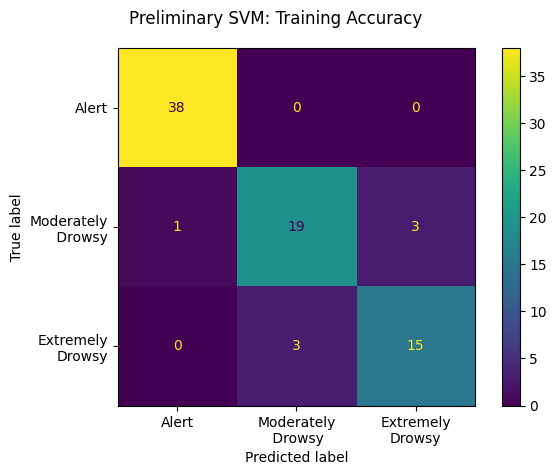

In [263]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [264]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 82.6087%
Accuracy of Extremely Drowsy: 83.3333%
----------------------------------------
Micro-average F1: 91.1392%
Weighted-average F1: 91.0490%
Macro-average F1: 88.8264%


* **Preliminary SVM: Testing Accuracy**

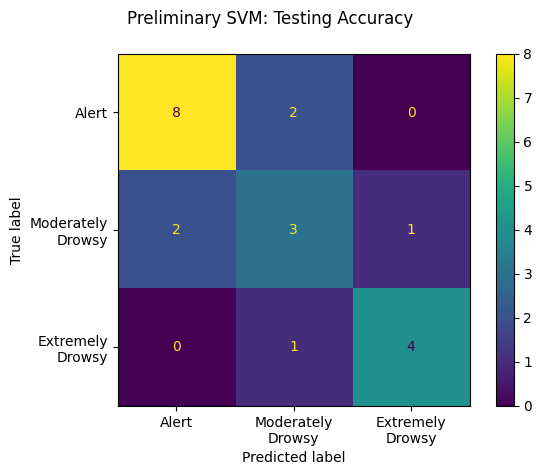

In [265]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [266]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 71.4286%
Weighted-average F1: 71.4286%
Macro-average F1: 70.0000%


In [267]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [268]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,2.0,False
56,56,1.0,2.0,False


##### **5.2 SVM + Optimized Parameters**

In [269]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8733


In [270]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

# clf_svm_cv = SVC(random_state=seed, C=10, gamma='scale', kernel='rbf')
clf_svm_cv = SVC(random_state=seed, **optimal_params.best_params_)
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=10, gamma='auto', random_state=42)

In [271]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_cv.pkl', "wb") as f:
    pickle.dump(clf_svm_cv, f)

* **Optimized SVM: Training Accuracy**

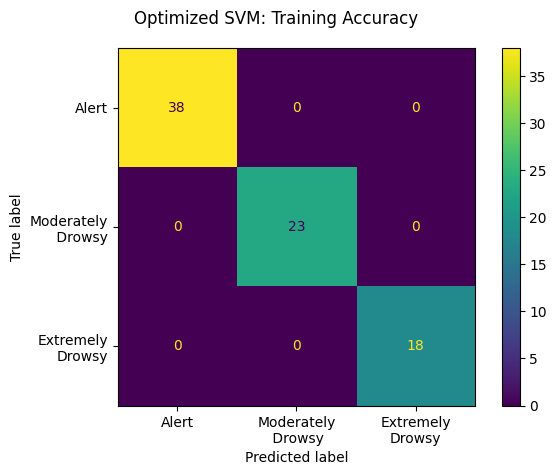

In [272]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [273]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized SVM: Testing Accuracy**

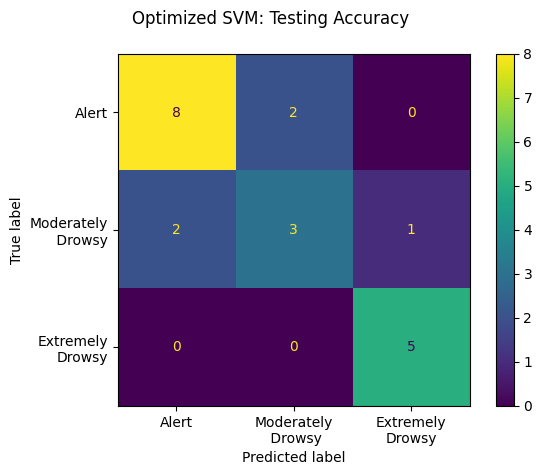

In [274]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [275]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 76.1905%
Weighted-average F1: 75.3247%
Macro-average F1: 75.1515%


In [276]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,2.0,False
56,56,1.0,2.0,False


##### **5.3 SVM with PCA**

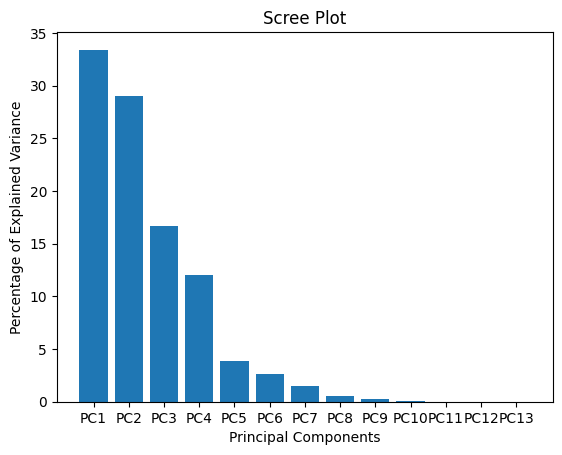

In [277]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [278]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_pca_transformer.pkl', "wb") as f:
    pickle.dump(pca_transformer, f)

In [279]:
X.columns

Index(['Epoch_minute', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative',
       'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF'],
      dtype='object')

In [280]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.421013
BetaRelative     -0.416715
TA_BRatio         0.345333
AlphaRelative    -0.342037
HF                0.259424
ThetaRelative    -0.252056
AlphaBetaRatio    0.250277
Epoch_minute      0.237804
pLF              -0.236557
pHF               0.236557
dtype: float64


In [281]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [282]:
clf_svm_pca = SVC(random_state=seed, **optimal_params.best_params_)
clf_svm_pca.fit(pca_train_scaled, y_train)

SVC(C=10, gamma=0.1, random_state=42)

In [283]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_pca.pkl', "wb") as f:
    pickle.dump(clf_svm_pca, f)

In [284]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

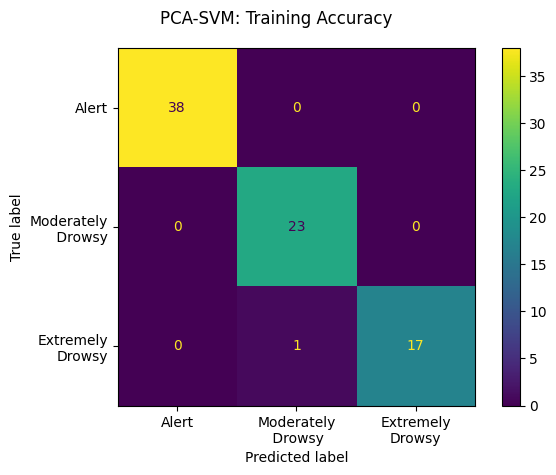

In [285]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [286]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 94.4444%
----------------------------------------
Micro-average F1: 98.7342%
Weighted-average F1: 98.7296%
Macro-average F1: 98.3384%


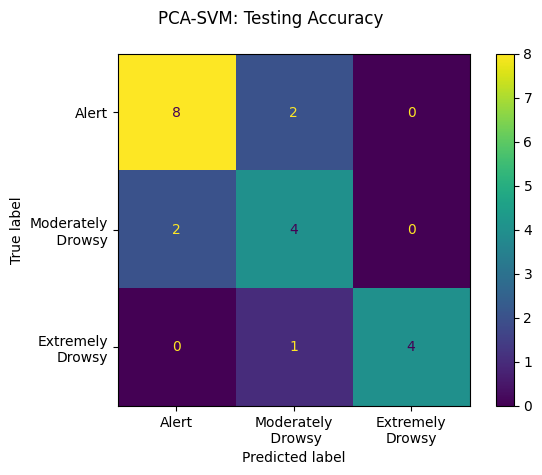

In [287]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [288]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 76.1905%
Weighted-average F1: 76.8417%
Macro-average F1: 76.8091%


In [289]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [290]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,2.0,False
51,51,1.0,1.0,True
56,56,1.0,2.0,False


## **6. K-Nearest Neighbors (KNN)**

##### **6.1 K-NN (Preliminary)**

In [291]:
import math
print(math.sqrt(len(y_train)))
print(math.sqrt(len(y_test)))

8.888194417315589
4.58257569495584


In [292]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_prelim = KNeighborsClassifier()
clf_knn_prelim.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [293]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_prelim.pkl', "wb") as f:
    pickle.dump(clf_knn_prelim, f)

* **Preliminary KNN: Training Accuracy**

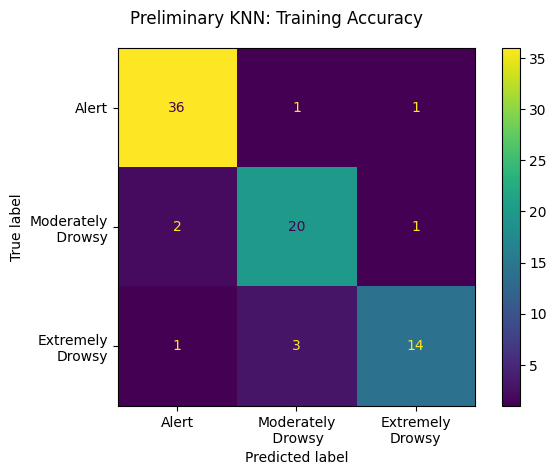

In [294]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary KNN: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [295]:
# Training Accuracy
classwise_accuracy(clf_knn_prelim, X_train_scaled, y_train)

Accuracy of Alert: 94.7368%
Accuracy of Moderately Drowsy: 86.9565%
Accuracy of Extremely Drowsy: 77.7778%
----------------------------------------
Micro-average F1: 88.6076%
Weighted-average F1: 88.5196%
Macro-average F1: 86.9886%


* **Preliminary KNN: Testing Accuracy**

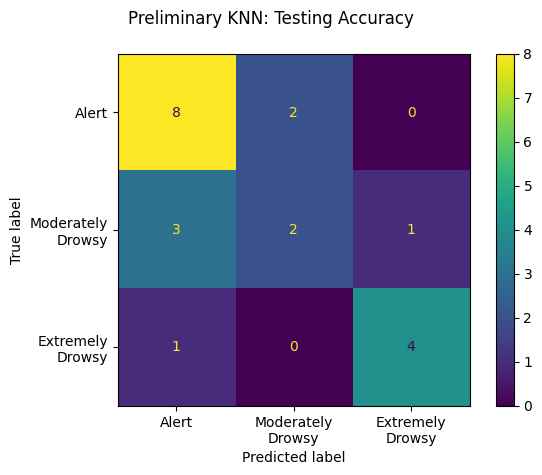

In [296]:
# Preliminary KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [297]:
# Testing Accuracy
classwise_accuracy(clf_knn_prelim, X_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 33.3333%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 66.6667%
Weighted-average F1: 65.1082%
Macro-average F1: 64.2424%


In [298]:
# Result Summary: Preliminary KNN (training)
result_summary(clf_knn_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,2.0,False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [299]:
# Result Summary: Preliminary KNN (testing)
result_summary(clf_knn_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,2.0,False
56,56,1.0,2.0,False


##### **6.2 K-NN + Optimized Parameters**

In [300]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,26)),
    # [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.8608333333333335


In [301]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_cv = KNeighborsClassifier(**optimal_params.best_params_)
clf_knn_cv.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [302]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_cv.pkl', "wb") as f:
    pickle.dump(clf_knn_cv, f)

* **Optimized KNN: Training Accuracy**

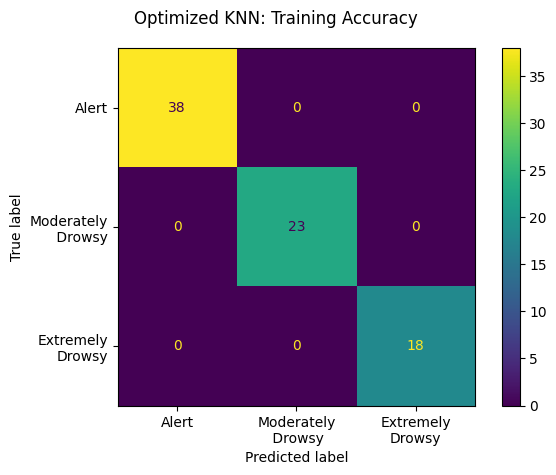

In [303]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Training Accuracy")
plt.tight_layout()
plt.show()

In [304]:
# Training Accuracy
classwise_accuracy(clf_knn_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized KNN: Testing Accuracy**

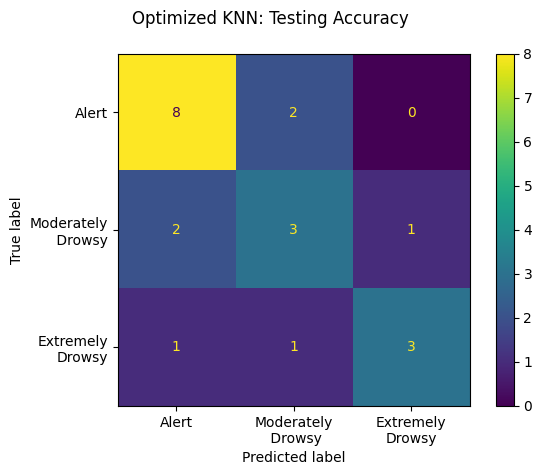

In [305]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [306]:
# Testing Accuracy
classwise_accuracy(clf_knn_cv, X_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 60.0000%
----------------------------------------
Micro-average F1: 66.6667%
Weighted-average F1: 66.4399%
Macro-average F1: 64.2857%


In [307]:
# Result Summary: Optimized SVM (training)
result_summary(clf_knn_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [308]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_knn_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,2.0,False
56,56,1.0,2.0,False


##### **6.3 KNN with PCA**

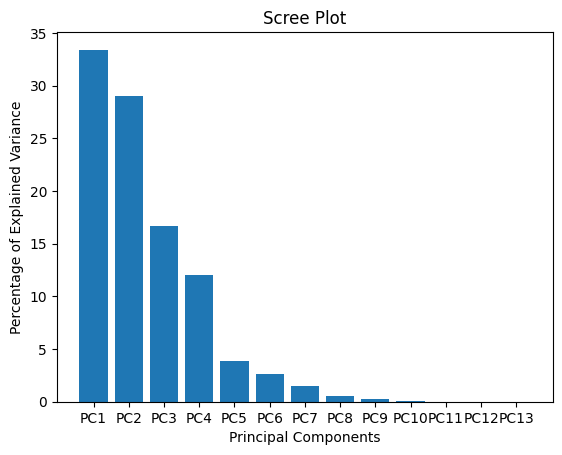

In [309]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [310]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.421013
BetaRelative     -0.416715
TA_BRatio         0.345333
AlphaRelative    -0.342037
HF                0.259424
ThetaRelative    -0.252056
AlphaBetaRatio    0.250277
Epoch_minute      0.237804
pLF              -0.236557
pHF               0.236557
dtype: float64


In [311]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [312]:
param_grid = {
    'n_neighbors': list(range(1,26)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.8866666666666667


In [313]:
clf_knn_pca = KNeighborsClassifier(**optimal_params.best_params_)
clf_knn_pca.fit(pca_train_scaled, y_train)

KNeighborsClassifier(weights='distance')

In [314]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_pca.pkl', "wb") as f:
    pickle.dump(clf_knn_pca, f)

In [315]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

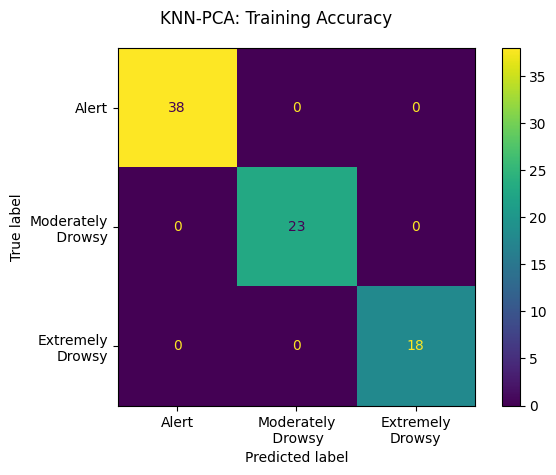

In [316]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("KNN-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [317]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_knn_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


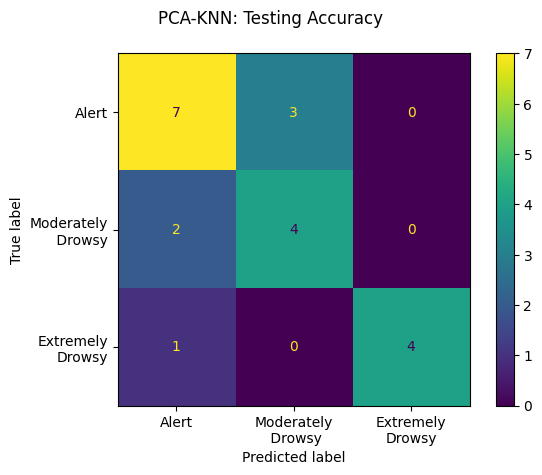

In [318]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-KNN: Testing Accuracy")
plt.tight_layout()
plt.show()


In [319]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_knn_pca, pca_test_scaled, y_test)

Accuracy of Alert: 70.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 71.4286%
Weighted-average F1: 72.0798%
Macro-average F1: 73.4758%


In [320]:
# Result Summary: KNN-PCA (training)
result_summary(clf_knn_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


## **7. Decision Tree** 

##### **7.1 Decision Tree (Preliminary)**

In [321]:
clf_dt_prelim = DecisionTreeClassifier()
clf_dt_prelim.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [322]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_prelim.pkl', "wb") as f:
    pickle.dump(clf_dt_prelim, f)

* **Preliminary DT: Training Accuracy**

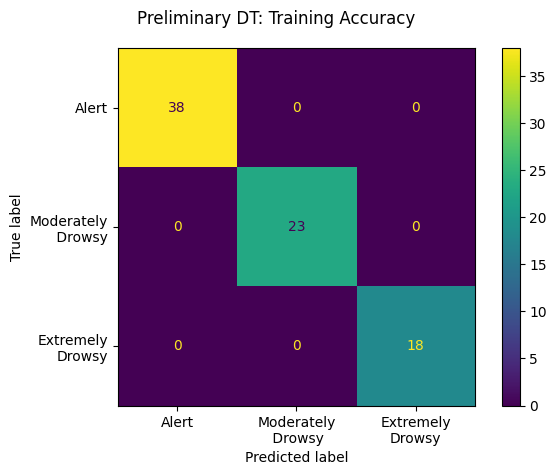

In [323]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary DT: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [324]:
# Training Accuracy
classwise_accuracy(clf_dt_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary DT: Testing Accuracy**

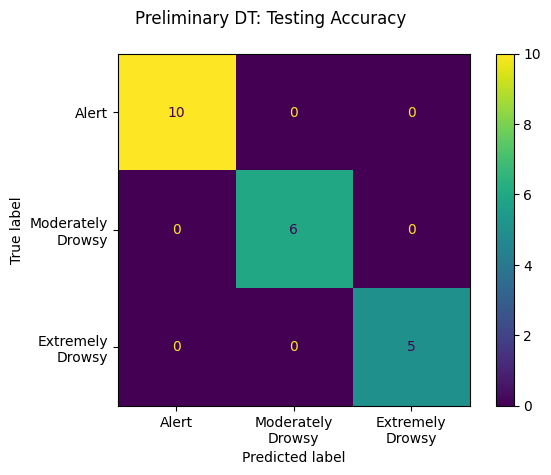

In [325]:
# Preliminary DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [326]:
# Testing Accuracy
classwise_accuracy(clf_dt_prelim, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


##### **7.2 Decision Tree + Optimized Parameters**

In [327]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}
Best cross-validation score: 0.9625


In [328]:
clf_dt_cv = DecisionTreeClassifier(**optimal_params.best_params_)
clf_dt_cv.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3)

In [329]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_cv.pkl', "wb") as f:
    pickle.dump(clf_dt_cv, f)

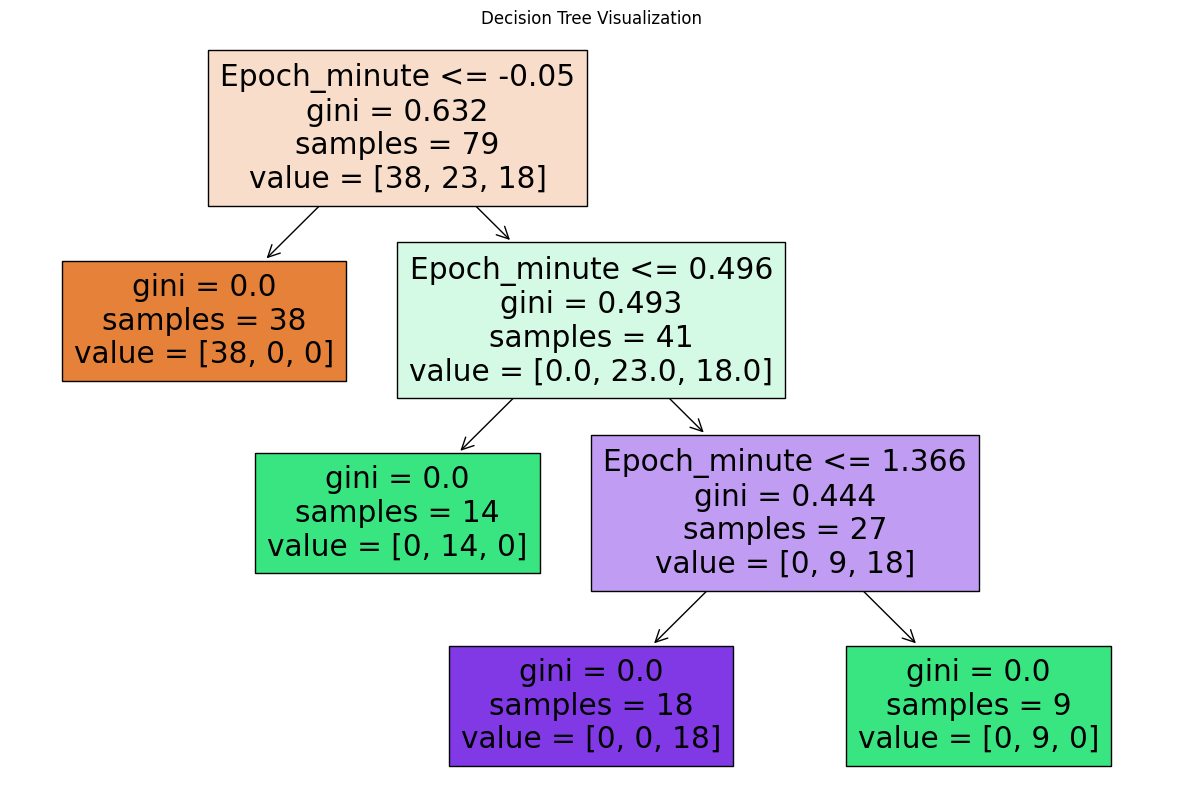

In [330]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(clf_dt_cv, ax = ax, feature_names = X.columns, filled = True)
plt.title("Decision Tree Visualization")
plt.show()

* **Optimized DT: Training Accuracy**

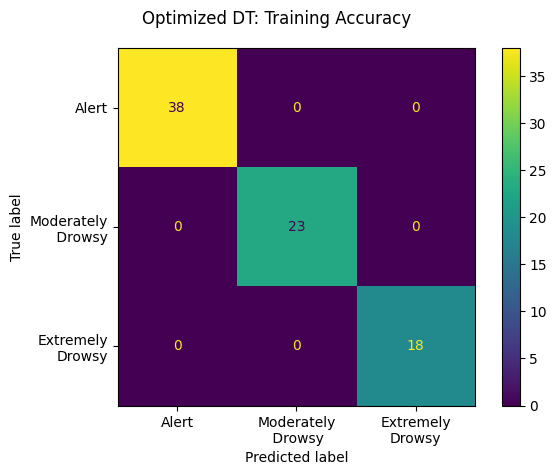

In [331]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Training Accuracy")
plt.tight_layout()
plt.show()

In [332]:
# Training Accuracy
classwise_accuracy(clf_dt_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized DT: Testing Accuracy**

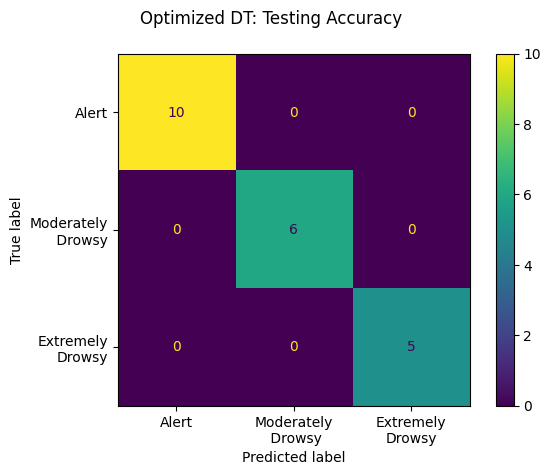

In [333]:
# Optimized DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [334]:
# Testing Accuracy
classwise_accuracy(clf_dt_cv, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


In [335]:
# Result Summary: Optimized SVM (training)
result_summary(clf_dt_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [336]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_dt_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,1.0,True
56,56,1.0,1.0,True


##### **7.3 Decision Tree with PCA**

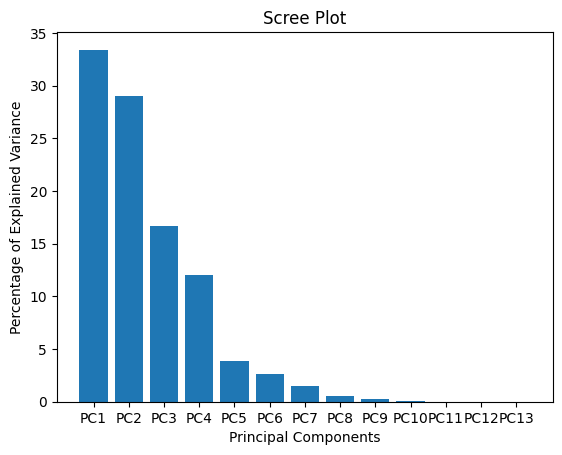

In [337]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [338]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.421013
BetaRelative     -0.416715
TA_BRatio         0.345333
AlphaRelative    -0.342037
HF                0.259424
ThetaRelative    -0.252056
AlphaBetaRatio    0.250277
Epoch_minute      0.237804
pLF              -0.236557
pHF               0.236557
dtype: float64


In [339]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [340]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score: 0.7316666666666667


In [341]:
clf_dt_pca = DecisionTreeClassifier(**optimal_params.best_params_)
clf_dt_pca.fit(pca_train_scaled, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=10)

In [342]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_pca.pkl', "wb") as f:
    pickle.dump(clf_dt_pca, f)

In [343]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

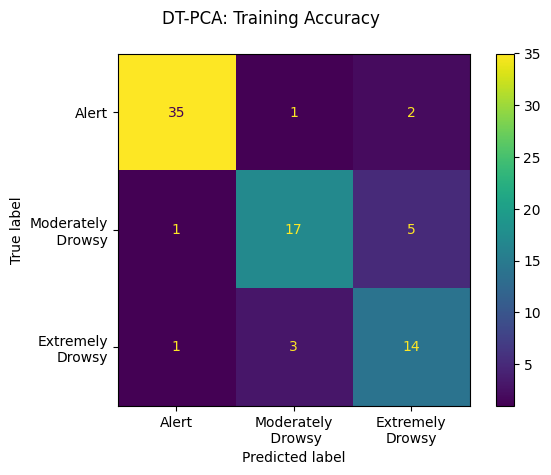

In [344]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("DT-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [345]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_dt_pca, pca_train_scaled, y_train)

Accuracy of Alert: 92.1053%
Accuracy of Moderately Drowsy: 73.9130%
Accuracy of Extremely Drowsy: 77.7778%
----------------------------------------
Micro-average F1: 83.5443%
Weighted-average F1: 83.7500%
Macro-average F1: 80.8003%


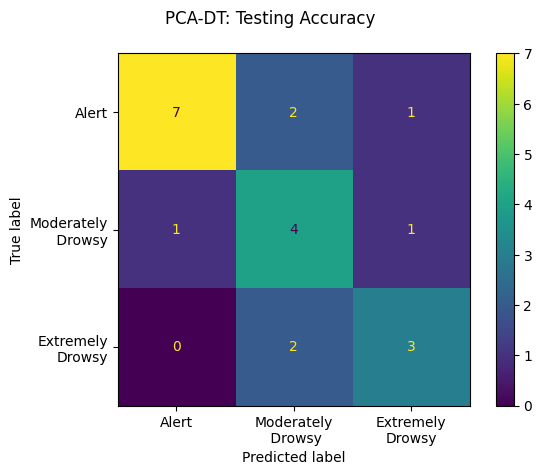

In [346]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-DT: Testing Accuracy")
plt.tight_layout()
plt.show()


In [347]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_dt_pca, pca_test_scaled, y_test)

Accuracy of Alert: 70.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 60.0000%
----------------------------------------
Micro-average F1: 66.6667%
Weighted-average F1: 67.6493%
Macro-average F1: 64.9735%


In [348]:
# Result Summary: KNN-PCA (training)
result_summary(clf_dt_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,2.0,False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


## **8. Random Forest**

##### **8.1 Random Forest (Preliminary)**

In [349]:
clf_rf_prelim = RandomForestClassifier()
clf_rf_prelim.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [350]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_prelim.pkl', "wb") as f:
    pickle.dump(clf_rf_prelim, f)

* **Preliminary RF: Training Accuracy**

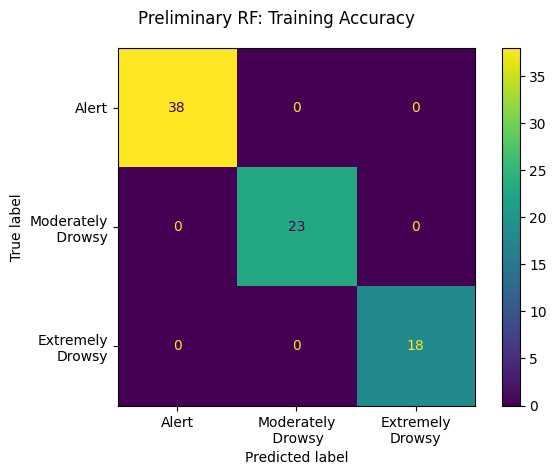

In [351]:
# Preliminary RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary RF: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [352]:
# Training Accuracy
classwise_accuracy(clf_rf_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary RF: Testing Accuracy**

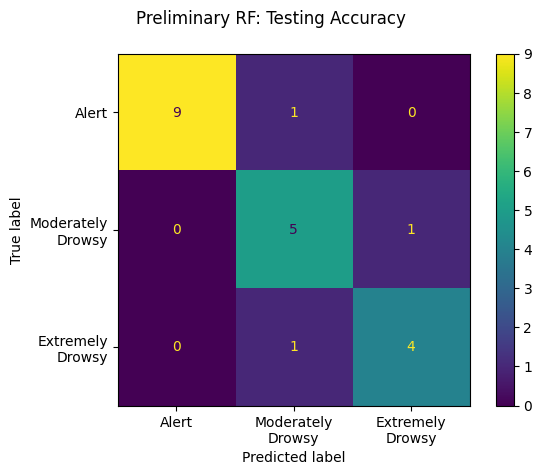

In [353]:
# Preliminary RF: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [354]:
# Testing Accuracy
classwise_accuracy(clf_rf_prelim, X_test_scaled, y_test)

Accuracy of Alert: 90.0000%
Accuracy of Moderately Drowsy: 83.3333%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 85.7143%
Weighted-average F1: 86.1384%
Macro-average F1: 83.8866%


In [355]:
# Result Summary: Preliminary RF (training)
result_summary(clf_rf_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [356]:
# Result Summary: Preliminary rf (testing)
result_summary(clf_rf_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,2.0,False
56,56,1.0,1.0,True


##### **8.2 Random Forest + Optimized Parameters**

In [357]:
param_grid = {
  'n_estimators': [100],  # Number of trees in the forest
  'max_depth': range(2, 5),  # Explore depths from 2 to 20
  'min_samples_split': range(2, 5),  # Minimum samples for a split (2 to 10)
  'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
  'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
optimal_params = GridSearchCV(
    clf,  # Use RandomForestClassifier here
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as scoring metric
    verbose=1,  # Print progress during search
    # estimator=tqdm(clf)
)

optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best cross-validation score: 0.885


In [358]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_rf_cv = RandomForestClassifier(**optimal_params.best_params_)
clf_rf_cv.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=3)

In [359]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_cv.pkl', "wb") as f:
    pickle.dump(clf_rf_cv, f)

* **Optimized RF: Training Accuracy**

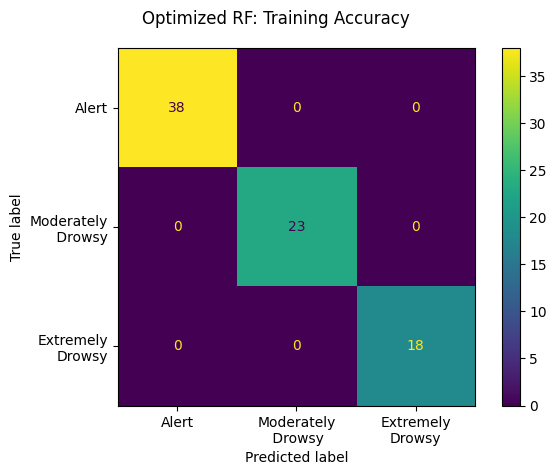

In [360]:
# Optimized RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Training Accuracy")
plt.tight_layout()
plt.show()

In [361]:
# Training Accuracy
classwise_accuracy(clf_rf_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized RF: Testing Accuracy**

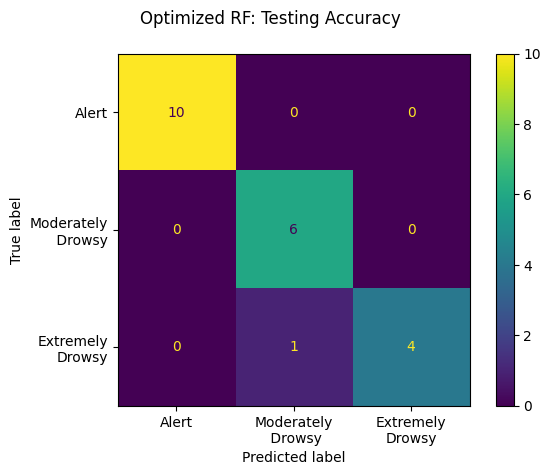

In [362]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [363]:
# Testing Accuracy
classwise_accuracy(clf_rf_cv, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 95.2381%
Weighted-average F1: 95.1567%
Macro-average F1: 93.7322%


In [364]:
# Result Summary: Optimized SVM (training)
result_summary(clf_rf_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [365]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_rf_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,1.0,True
51,51,1.0,1.0,True
56,56,1.0,1.0,True


##### **8.3 Random Forest with PCA**

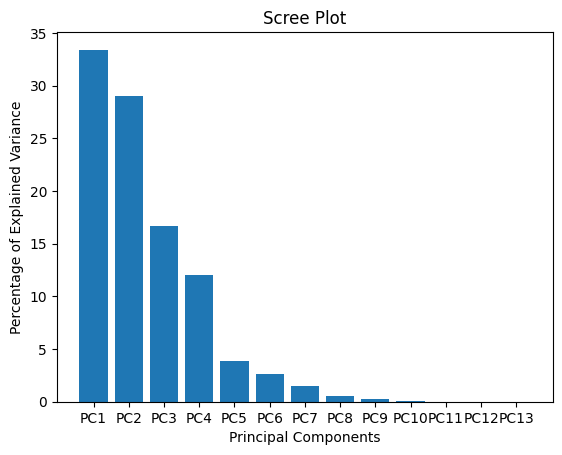

In [366]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [367]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.421013
BetaRelative     -0.416715
TA_BRatio         0.345333
AlphaRelative    -0.342037
HF                0.259424
ThetaRelative    -0.252056
AlphaBetaRatio    0.250277
Epoch_minute      0.237804
pLF              -0.236557
pHF               0.236557
dtype: float64


In [368]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

In [369]:
param_grid = {
  'n_estimators': [100],  # Number of trees in the forest
  'max_depth': range(2, 5),  # Explore depths from 2 to 20
  'min_samples_split': range(2, 5),  # Minimum samples for a split (2 to 10)
  'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
  'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
optimal_params = GridSearchCV(
    clf,  # Use RandomForestClassifier here
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as scoring metric
    verbose=1,  # Print progress during search

)

optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}
Best cross-validation score: 0.8216666666666667


In [370]:
clf_rf_pca = RandomForestClassifier(**optimal_params.best_params_)
clf_rf_pca.fit(pca_train_scaled, y_train)

RandomForestClassifier(max_depth=4, max_features='log2', min_samples_leaf=3,
                       min_samples_split=3)

In [371]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_pca.pkl', "wb") as f:
    pickle.dump(clf_rf_pca, f)

In [372]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

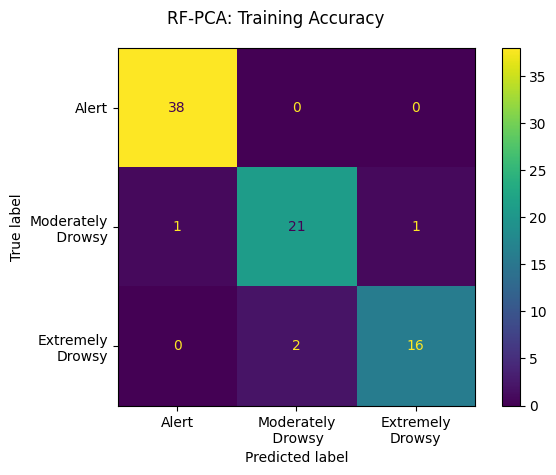

In [373]:
# PCA-RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("RF-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [374]:
# PCA-RF: Training Accuracy
classwise_accuracy(clf_rf_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 91.3043%
Accuracy of Extremely Drowsy: 88.8889%
----------------------------------------
Micro-average F1: 94.9367%
Weighted-average F1: 94.8907%
Macro-average F1: 93.8114%


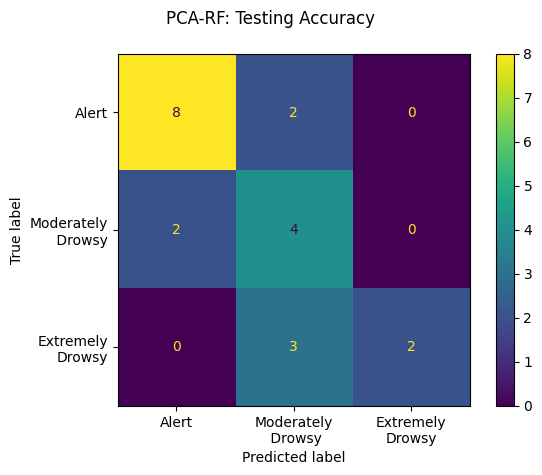

In [375]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-RF: Testing Accuracy")
plt.tight_layout()
plt.show()


In [376]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_rf_pca, pca_test_scaled, y_test)

Accuracy of Alert: 80.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 40.0000%
----------------------------------------
Micro-average F1: 66.6667%
Weighted-average F1: 66.9388%
Macro-average F1: 63.4921%


In [377]:
# Result Summary: RF-PCA (training)
result_summary(clf_rf_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True


In [378]:
# Result Summary: KNN-PCA (testing)
result_summary(clf_rf_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
7,7,1.0,1.0,True
10,10,1.0,1.0,True
14,14,1.0,1.0,True
18,18,1.0,1.0,True
20,20,1.0,1.0,True
22,22,1.0,1.0,True
37,37,1.0,1.0,True
47,47,1.0,2.0,False
51,51,1.0,1.0,True
56,56,1.0,2.0,False


# **Combined Cases**

## **1. Import Libraries**

In [1]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

## **2. Function**

In [2]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    
    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min

## **2. Import the Data**

##### 2.1 Load the .mat file (input) and .csv file (output)

In [3]:
subject_list = []

while True:
    subject = input('subject: ')
    if subject == '':
        break  # Exit the loop if no input is provided and just Enter is pressed.
    else:
        try:
            # Convert the input to an integer and add it to the list
            subject_number = int(subject)
            subject_list.append(subject_number)
        except ValueError:
            # Handle the case where the input is not an integer
            print("Please enter a valid number or press Enter to finish.")

print("Subjects entered:", subject_list)


Subjects entered: [1, 2]


In [4]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []

for subject in subject_list:
    ECG_features, EEG_features, ord_60min = load_subject_data(subject)
    EEG_features_allcases.append(EEG_features)
    ECG_features_allcases.append(ECG_features)
    ord_60min_allcases.append(ord_60min)



In [5]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [6]:
n = 0
for i in range(len(ECG_features_allcases)):
    print(i)

0
1


##### **2.2 [ECG] Create dataframe of selected ECG features** (ECG_features_df)

- *ECG_features_df*: (Index, VLF, LF, HF, LFHF, pLF, pHF)
- ecg_data
- ecg_timestamps_data
- rri_data
- rri_timestamps_data
- rpeak_timestamps_data

In [36]:
ECG_features_py = []

for subject_order in range(len(ECG_features_allcases)):
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject_order].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject_order][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)
        

    # Convert scalar values to DataFrame
ECG_features_df = pd.DataFrame(ECG_features_py)
print(ECG_features_df.shape)
ECG_features_df.head()

(278, 7)


,Index,VLF,LF,HF,LFHF,pLF,pHF
0,1,1.222879,0.680559,0.202004,3.369041,77.111682,22.888318
1,2,1.276459,0.493896,0.320742,1.539856,60.627684,39.372316
2,3,0.849887,0.529199,0.730583,0.724351,42.007180,57.992820
3,4,1.081928,0.729528,0.303516,2.403592,70.619272,29.380728
4,5,1.347853,0.493355,0.271716,1.815699,64.484846,35.515154


##### **2.3 [EEG] Create dataframe of selected EEG features** (EEG_features_df)


- *EEG_features_df_list*: List of 12 dataframes, containing selected EEG features from 12 EEG channels

In [37]:
EEG_features_df_list = []

numEEGchannels = EEG_features.shape[1]
numEEGepochs = EEG_features.shape[0]
EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

# Assuming struct_array is of shape (139, 12), iterate through each struct
for channel in range(numEEGchannels):  # for j in range(12)
    channelfeatures = []
    for subject_order in range(len(EEG_features_allcases)):
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject_order][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)   
    channelfeatures_df = pd.DataFrame(channelfeatures)
    EEG_features_df_list.append(channelfeatures_df)

In [38]:
print(EEG_features_df_list[0].shape)
EEG_example = EEG_features_df_list[0]

(278, 7)


In [39]:
EEG_features_df_list[0].head() # Features from Channel 1

,Epoch,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio
0,1,0.487397,0.130755,0.174339,0.195093,0.893624,1.563844
1,2,0.454033,0.126380,0.236338,0.178224,1.326071,2.035177
2,3,0.467654,0.105233,0.257013,0.163588,1.571093,2.214371
3,4,0.462228,0.131892,0.204637,0.194602,1.051564,1.729314
4,5,0.448262,0.137997,0.194415,0.211110,0.920916,1.574587


- *EEG_features_df*: The dataframe of selected EEG features (*Epoch, DeltaRelative, ThetaRelative, AlphaRelative, BetaRelative, AlphaBetaRatio, TA_BRatio*)

In [40]:
EEG_channel = int(input('EEG Channel: '))
EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
EEG_features_df

,Epoch,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio
0,1,0.487397,0.130755,0.174339,0.195093,0.893624,1.563844
1,2,0.454033,0.126380,0.236338,0.178224,1.326071,2.035177
2,3,0.467654,0.105233,0.257013,0.163588,1.571093,2.214371
3,4,0.462228,0.131892,0.204637,0.194602,1.051564,1.729314
4,5,0.448262,0.137997,0.194415,0.211110,0.920916,1.574587
...,...,...,...,...,...,...,...
273,135,0.607037,0.117293,0.128316,0.138625,0.925637,1.771756
274,136,0.658586,0.094279,0.143415,0.104248,1.375708,2.280081
275,137,0.555067,0.104456,0.243994,0.100171,2.435776,3.478552
276,138,0.632284,0.125575,0.147884,0.097815,1.511872,2.795675


##### **2.4 [ORD] Create dataframe of ORD labels for each epoch** (ORD_epoch)


**1) Converting *ord_60min* to *ord_epoch***
- ***ord_60min***: ORD labels for each minute
- ***ord_epoch***: ORD labels for each epoch (1-minute length with 50% overlap)

In [ ]:
display(ord_60min.head())
print(len(ord_60min))

,Minutes,Rater 1,Rater 2,Mean
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,1.0,1.0
4,5,1.0,1.0,1.0


60


In [ ]:
ord_epoch = []

for i in range(len(ord_60min) - 1):
    # Append the current ORD value
    ord_epoch.append(ord_60min.iloc[i, 3])
    
    # Calculate and append the mean of the current and next ORD values
    mean_ord = np.mean([ord_60min.iloc[i, 3], ord_60min.iloc[i + 1, 3]])
    ord_epoch.append(mean_ord)

# Append the last ORD value since it won't have a subsequent value to average with
ord_epoch.append(ord_60min.iloc[-1, 3])

# Convert the list to a DataFrame and set the column title as 'ord score'
ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

ord_epoch

,ORD score
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
114,3.0
115,3.0
116,3.0
117,3.0



**2) Simplify ORD labels to 3 classes**


'ORD class' is assigned for each epoch based on this criteria
- *Alert*: ORD score <= 2 
- *Moderately Drowsy*: 2 < ORD score <= 3
- *Extremely Drowsy*: ORD score > 3

In [ ]:
# # Check if The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n
# ord_60min_array = ord_60min.iloc[:, 3].to_numpy()

# # Initialize a flag to keep track of discrepancies
# discrepancy_found = False

# ord_epoch_array = ord_epoch.iloc[:, 0].to_numpy()  # Convert to numpy array for easy indexing

# # Loop through the ord_60min_array and compare with ord_epoch_array
# for n in range(len(ord_60min_array)):
#     if ord_60min_array[n] != ord_epoch_array[2*n]:
#         print(f"Discrepancy found at minute {n}: {ord_60min_array[n]} != {ord_epoch_array[2*n]}")
#         discrepancy_found = True
#         break

# if not discrepancy_found:
#     print("All checks passed: The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n.")


In [ ]:
# Add 'ORD class' column based on 'ord score' values
ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

# Mapping from 'ORD class' to 'class name'
class_name_mapping = {
    1: 'Alert',
    2: 'Moderately Drowsy',
    3: 'Extremely Drowsy'
}

# Add 'class name' column by mapping 'ORD class' to names
ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

print(ord_epoch)

     ORD score  ORD class         class name
0          1.0        1.0              Alert
1          1.0        1.0              Alert
2          1.0        1.0              Alert
3          1.0        1.0              Alert
4          1.0        1.0              Alert
..         ...        ...                ...
114        3.0        2.0  Moderately Drowsy
115        3.0        2.0  Moderately Drowsy
116        3.0        2.0  Moderately Drowsy
117        3.0        2.0  Moderately Drowsy
118        3.0        2.0  Moderately Drowsy

[119 rows x 3 columns]


In [ ]:
# Count the epochs of each 'ORD class'
class_counts = ord_epoch['class name'].value_counts()
print(class_counts)

class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64


##### **2.5 Create dataframe of EEG features, ECG features, ORD labels for each epoch** (combined_data)

sync data from each dataframe, including only epochs in the 60-minute driving phase

In [ ]:
# EEG_features_df (df 139x7): row 10-128, column 1-6
# ECG_features_df (df 139x7): row 10-128, column 1-6
# ord_epoch (df 119x3): all row, column 1-2

# 1) Select the specified rows and columns from each DataFrame
EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

# 2) Combine these features into a new DataFrame
# Concatenate EEG and ECG features along the columns
combined_data = pd.concat([Epoch_minute.reset_index(drop=True),
                               EEG_features_selected.reset_index(drop=True), 
                               ECG_features_selected.reset_index(drop=True),
                               ord_epoch_selected.reset_index(drop=True)], axis=1)
combined_data = combined_data.dropna()

# Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
print(combined_data.shape)
combined_data

(100, 15)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.775866,0.064320,0.035202,0.111564,0.315532,0.892063,0.563618,1.322986,0.240017,5.512040,84.643828,15.356172,1.0,Alert
1,1.5,0.790315,0.074270,0.034407,0.091584,0.375689,1.186639,0.334687,0.928440,0.802207,1.157357,53.646978,46.353022,1.0,Alert
2,2.0,0.802925,0.061003,0.030293,0.094883,0.319263,0.962190,0.369949,1.413259,0.300318,4.705880,82.474220,17.525780,1.0,Alert
3,2.5,0.780075,0.055084,0.031169,0.115924,0.268873,0.744049,0.116496,1.710847,0.281581,6.075851,85.867424,14.132576,1.0,Alert
4,3.0,0.735872,0.060959,0.039615,0.141814,0.279340,0.709189,0.530470,1.115107,0.430995,2.587285,72.123765,27.876235,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,0.865729,0.062642,0.025736,0.045394,0.566942,1.946889,0.147377,1.200727,0.711522,1.687548,62.791365,37.208635,2.0,Moderately Drowsy
115,58.5,0.842878,0.071818,0.034329,0.051391,0.667999,2.065480,0.379912,1.084971,0.597031,1.817277,64.504736,35.495264,2.0,Moderately Drowsy
116,59.0,0.823283,0.080187,0.032465,0.062621,0.518432,1.798946,0.492459,1.144754,0.437127,2.618813,72.366626,27.633374,2.0,Moderately Drowsy
117,59.5,0.849834,0.066574,0.029438,0.053594,0.549280,1.791469,0.459380,1.247259,0.391620,3.184870,76.104396,23.895604,2.0,Moderately Drowsy
